# 📌 Projet : Prédiction de souscription à un dépôt bancaire


# 📊 Projet Machine Learning : Prédiction de souscription bancaire

## 🎯 Objectif
L’objectif de ce projet est de prédire si un client va souscrire à un **dépôt à terme** (`y`) à partir de données issues de **campagnes de télémarketing** menées par une banque portugaise.

## 📄 Contexte
Ce projet s’appuie sur le dataset utilisé dans l’article de :
> Moro, Cortez & Rita (2014) – *A Data-Driven Approach to Predict the Success of Bank Telemarketing*

Le dataset contient :
- **41 188 clients** (lignes)
- **20 variables explicatives**
- **1 variable cible `y`** indiquant si le client a souscrit (`yes`) ou non (`no`)

## 🛠️ Méthodologie
- Analyse exploratoire des données
- Prétraitement (encodage, normalisation, sélection de variables)
- Gestion du déséquilibre (SMOTE)
- Modélisation : KNN, Arbre de Décision, Random Forest
- Évaluation : Accuracy, F1-score, AUC-ROC




##  Description des variables (bank-additional-full.csv)

| Variable           | Description courte                   |
|--------------------|---------------------------------------|
| **age**            | Âge du client                         |
| **job**            | Métier du client                      |
| **marital**        | Situation matrimoniale                |
| **education**      | Niveau d’éducation                    |
| **default**        | Crédit en défaut                      |
| **housing**        | Prêt immobilier                       |
| **loan**           | Prêt personnel                        |
| **contact**        | Type de contact                       |
| **month**          | Mois du dernier contact               |
| **day_of_week**    | Jour du dernier contact               |
| **duration**       | Durée de l’appel (en secondes)        |
| **campaign**       | Nb d'appels durant la campagne        |
| **pdays**          | Jours depuis dernier contact          |
| **previous**       | Nb d’anciens contacts                 |
| **poutcome**       | Résultat de la campagne précédente    |
| **emp.var.rate**   | Variation taux d'emploi (éco)         |
| **cons.price.idx** | Indice des prix (conso)               |
| **cons.conf.idx**  | Indice de confiance (conso)           |
| **euribor3m**      | Taux Euribor 3 mois                   |
| **nr.employed**    | Nombre de salariés (éco)              |
| **y**              | Souscription dépôt à terme (cible)    |


In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score





## 1- Collecte des données

Nous allons préparer les données pour l'entraînement à partir du fichier csv fournit :



### 1.1 Charger les données :

In [235]:
df1 = pd.read_csv("bank-additional-full.csv", sep=';')
print("Dimensions du dataset :", df1.shape)
df1.head()


Dimensions du dataset : (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


##  2- Vérification de la qualité des données
### 2.1- Identification des valeurs "unknown"

Certaines colonnes contiennent des valeurs "unknown". Ces valeurs ne sont pas considérées comme des `NaN`, mais comme des **catégories à part entière**.   
Supprimer ces lignes pourrait réduire la taille du dataset et introduire un biais.  
➡️ Nous choisissons donc de **conserver "unknown" comme une modalité distincte**.


In [236]:
# Détection des valeurs "unknown"
(df1 == 'unknown').sum().sort_values(ascending=False)


default           8597
education         1731
housing            990
loan               990
job                330
marital             80
age                  0
poutcome             0
nr.employed          0
euribor3m            0
cons.conf.idx        0
cons.price.idx       0
emp.var.rate         0
duration             0
previous             0
pdays                0
campaign             0
day_of_week          0
month                0
contact              0
y                    0
dtype: int64

- `job`, `marital`, `housing`, `loan`, `education` → contiennent un faible pourcentage de `"unknown"` (≲ 5%) → **conservés et traités comme une modalité normale**
- `default` → contient plus de 20% de `"unknown"`, ce qui est significatif.


In [237]:
# Création d'une copie du dataset pour modification
df = df1.copy()

# Séparation des colonnes par type
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Variables catégorielles :", cat_cols)
print("Variables numériques :", num_cols)


Variables catégorielles : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Variables numériques : ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']



### 2.2 Vérification des doublons:

In [238]:
nb_doublons = df.duplicated().sum()
print(f"Nombre de doublons : {nb_doublons}")


Nombre de doublons : 12


On remarque qu'on a 12 doublons donc on va les traiter en les supprimant

- Suppression des doublons 

In [239]:
df = df.drop_duplicates()

### 2.3- Détection d'outliers simples

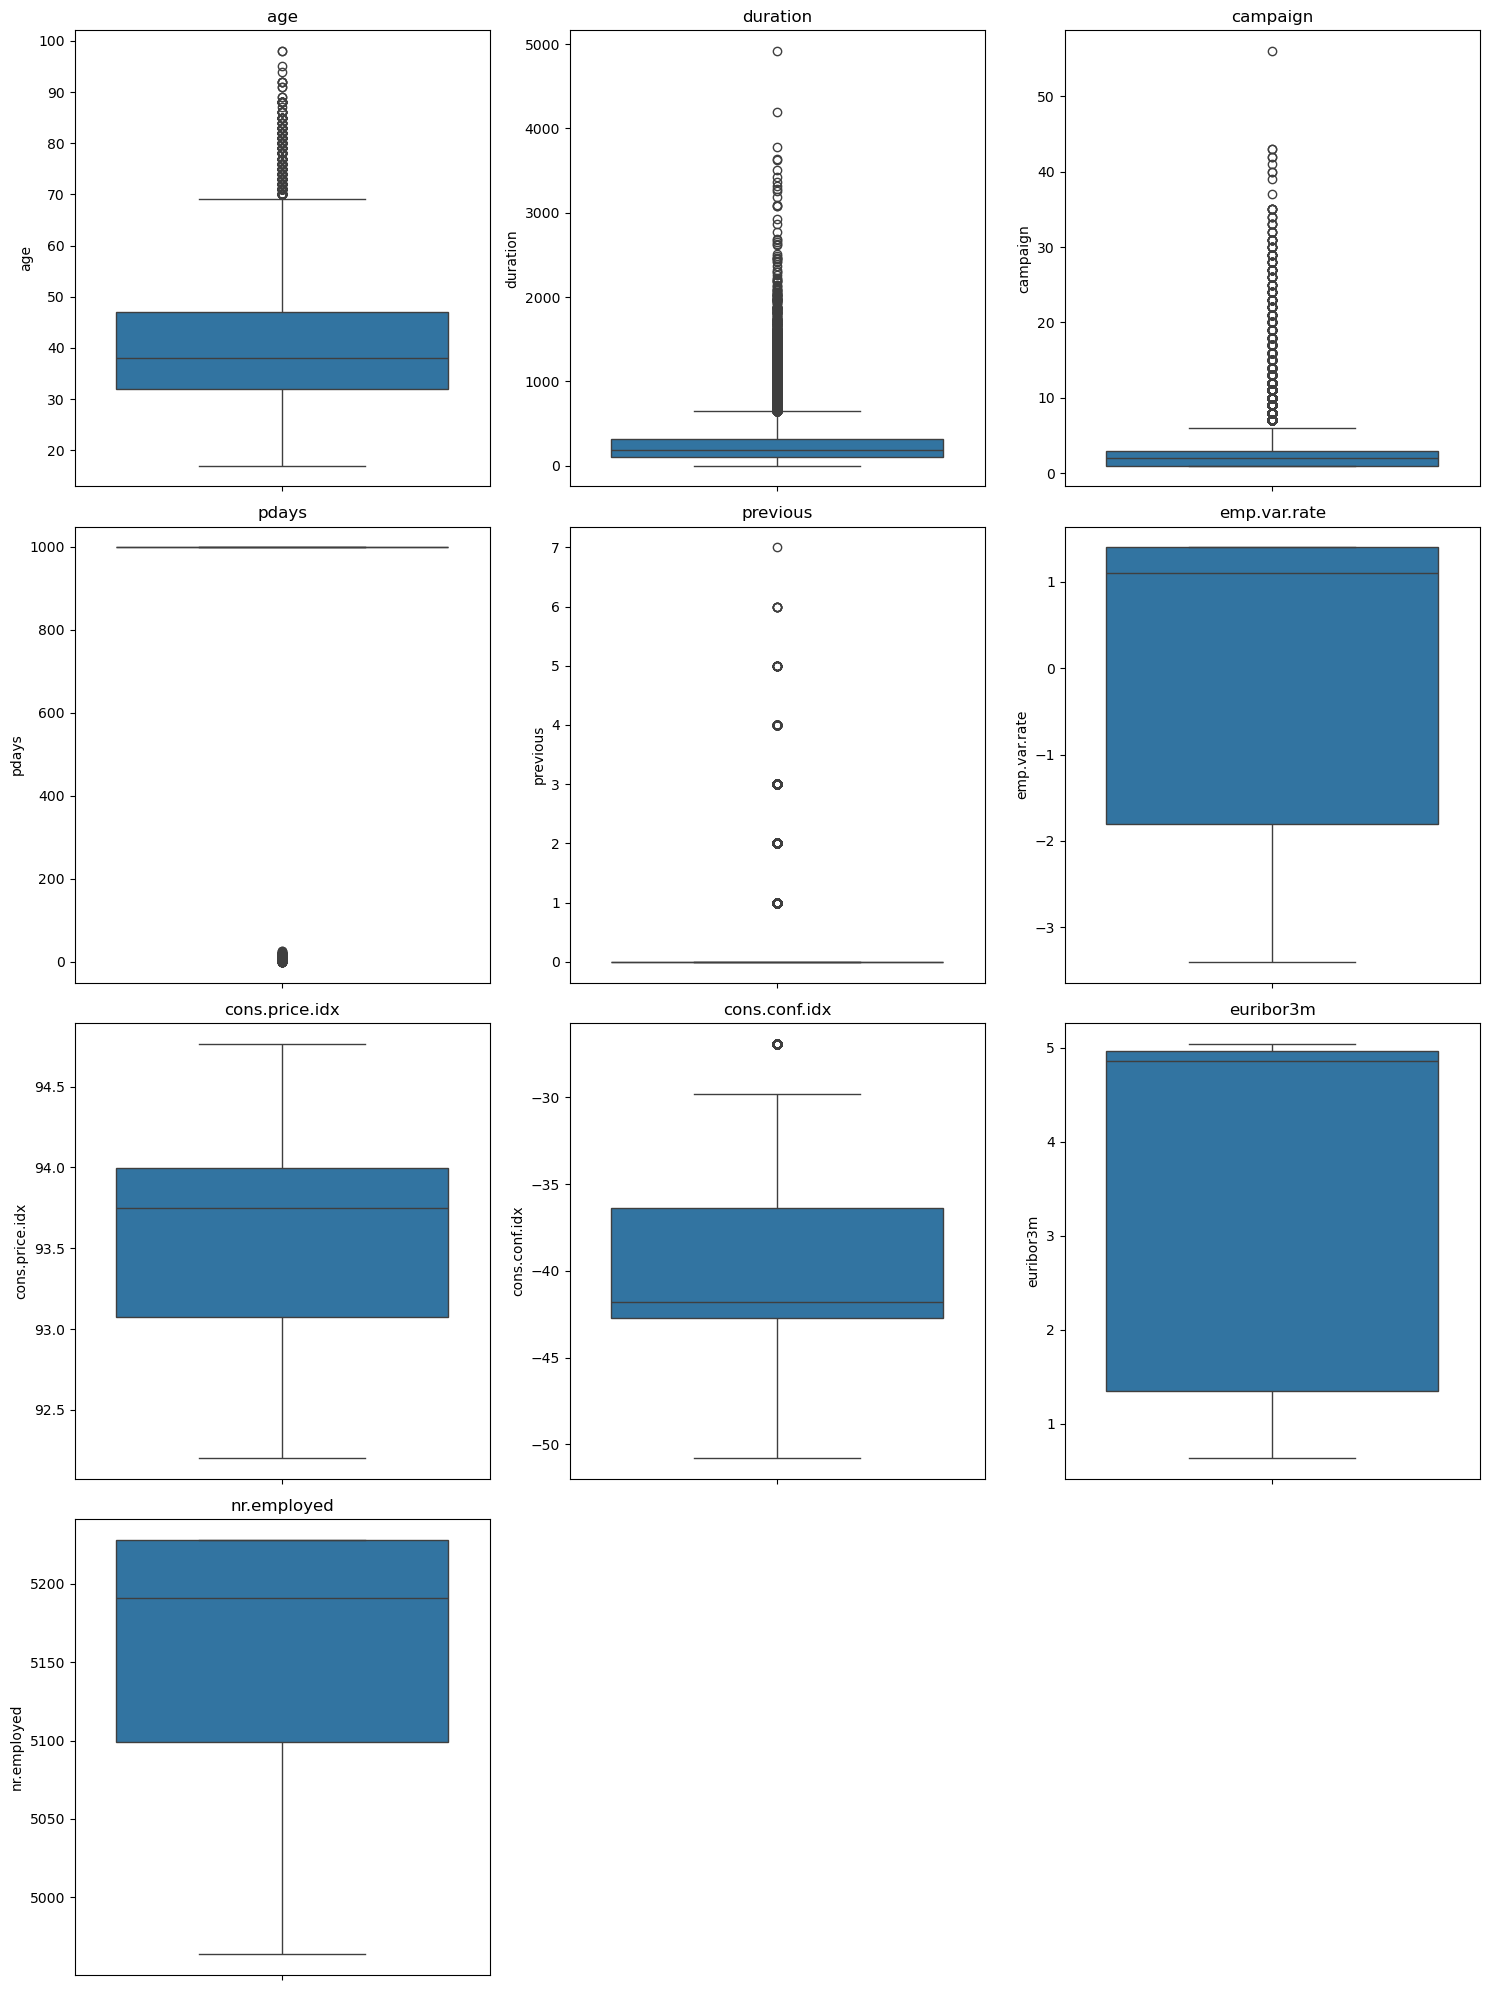

In [240]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
n = len(num_cols)
plt.figure(figsize=(15, 5 * ((n // 3) + 1)))
for i, col in enumerate(num_cols):
    plt.subplot((n // 3) + 1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

- Les variables campaign et previous affichent également une distribution asymétrique, avec une concentration très forte autour de petites valeurs et quelques extrêmes. Elles peuvent être transformées (log) ou gardées telles quelles selon le modèle

- La variable pdays montre une valeur très élevée (999) utilisée pour signifier qu’un client n’a jamais été contacté auparavant. Cette codification est difficile à interpréter directement ; une version binaire (ex. was_contacted) est préférable.

- Les variables économiques euribor3m, emp.var.rate et nr.employed sont concentrées mais redondantes. On gardera la plus interprétable (euribor3m) pour éviter la multicolinéarité

In [241]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('y', errors='ignore')
# Vérification de la qualité des données
# Identification des valeurs "unknown"
# Gestion des types de variables
# Création d'une copie propre du dataset

print("\nVariables avec outliers potentiels (Z-score > 3) :")
outlier_counts = {}
for col in numerical_cols:
    z = zscore(df[col])
    outliers = (abs(z) > 3).sum()
    if outliers > 0:
        outlier_counts[col] = outliers
        print(f"{col} : {outliers} valeurs extrêmes ({outliers / len(df) * 100:.2f}%)")


Variables avec outliers potentiels (Z-score > 3) :
age : 369 valeurs extrêmes (0.90%)
duration : 861 valeurs extrêmes (2.09%)
campaign : 869 valeurs extrêmes (2.11%)
pdays : 1515 valeurs extrêmes (3.68%)
previous : 1064 valeurs extrêmes (2.58%)


In [242]:
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\n{col} : {df[col].unique()}")

print("\nDistribution de y :")
print(df['y'].value_counts(normalize=True))


job : ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital : ['married' 'single' 'divorced' 'unknown']

education : ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default : ['no' 'unknown' 'yes']

housing : ['no' 'yes' 'unknown']

loan : ['no' 'yes' 'unknown']

contact : ['telephone' 'cellular']

month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week : ['mon' 'tue' 'wed' 'thu' 'fri']

poutcome : ['nonexistent' 'failure' 'success']

y : ['no' 'yes']

Distribution de y :
y
no     0.887337
yes    0.112663
Name: proportion, dtype: float64


## 3. Analyse de la variable cible 'y' et des autres variables en relation 
### 3.1 Distribution de y

In [243]:
print(df['y'].value_counts())
print(df['y'].value_counts(normalize=True) * 100)

y
no     36537
yes     4639
Name: count, dtype: int64
y
no     88.733728
yes    11.266272
Name: proportion, dtype: float64


#### 3.2 Affichage de la Répartition de la variable cible (y):


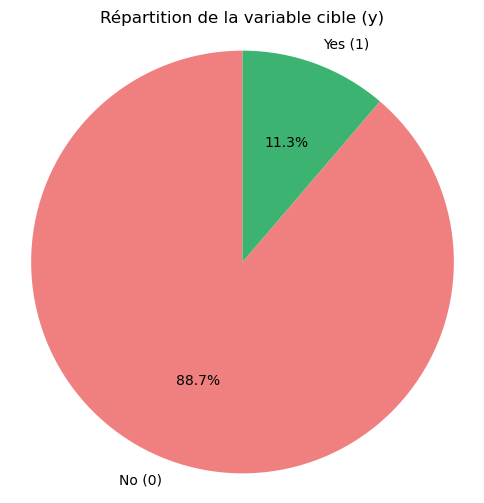

In [244]:
labels = ['No (0)', 'Yes (1)']
sizes = df['y'].value_counts(normalize=True) * 100
colors = ['lightcoral', 'mediumseagreen']
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Répartition de la variable cible (y)")
plt.axis('equal')
plt.show()

#### remarque : 
- La grande majorité des clients ont répondu **"no"**
- Seule une **petite proportion** (~11%) a souscrit à l’offre
- Vu que les  yes sont beaucoup plus faible que les non ce resultat dois être pris en compte car l'entraiment  d'un modèle de classification sue ces données pourait ne produire que des non.

##### distribution des variables numérique

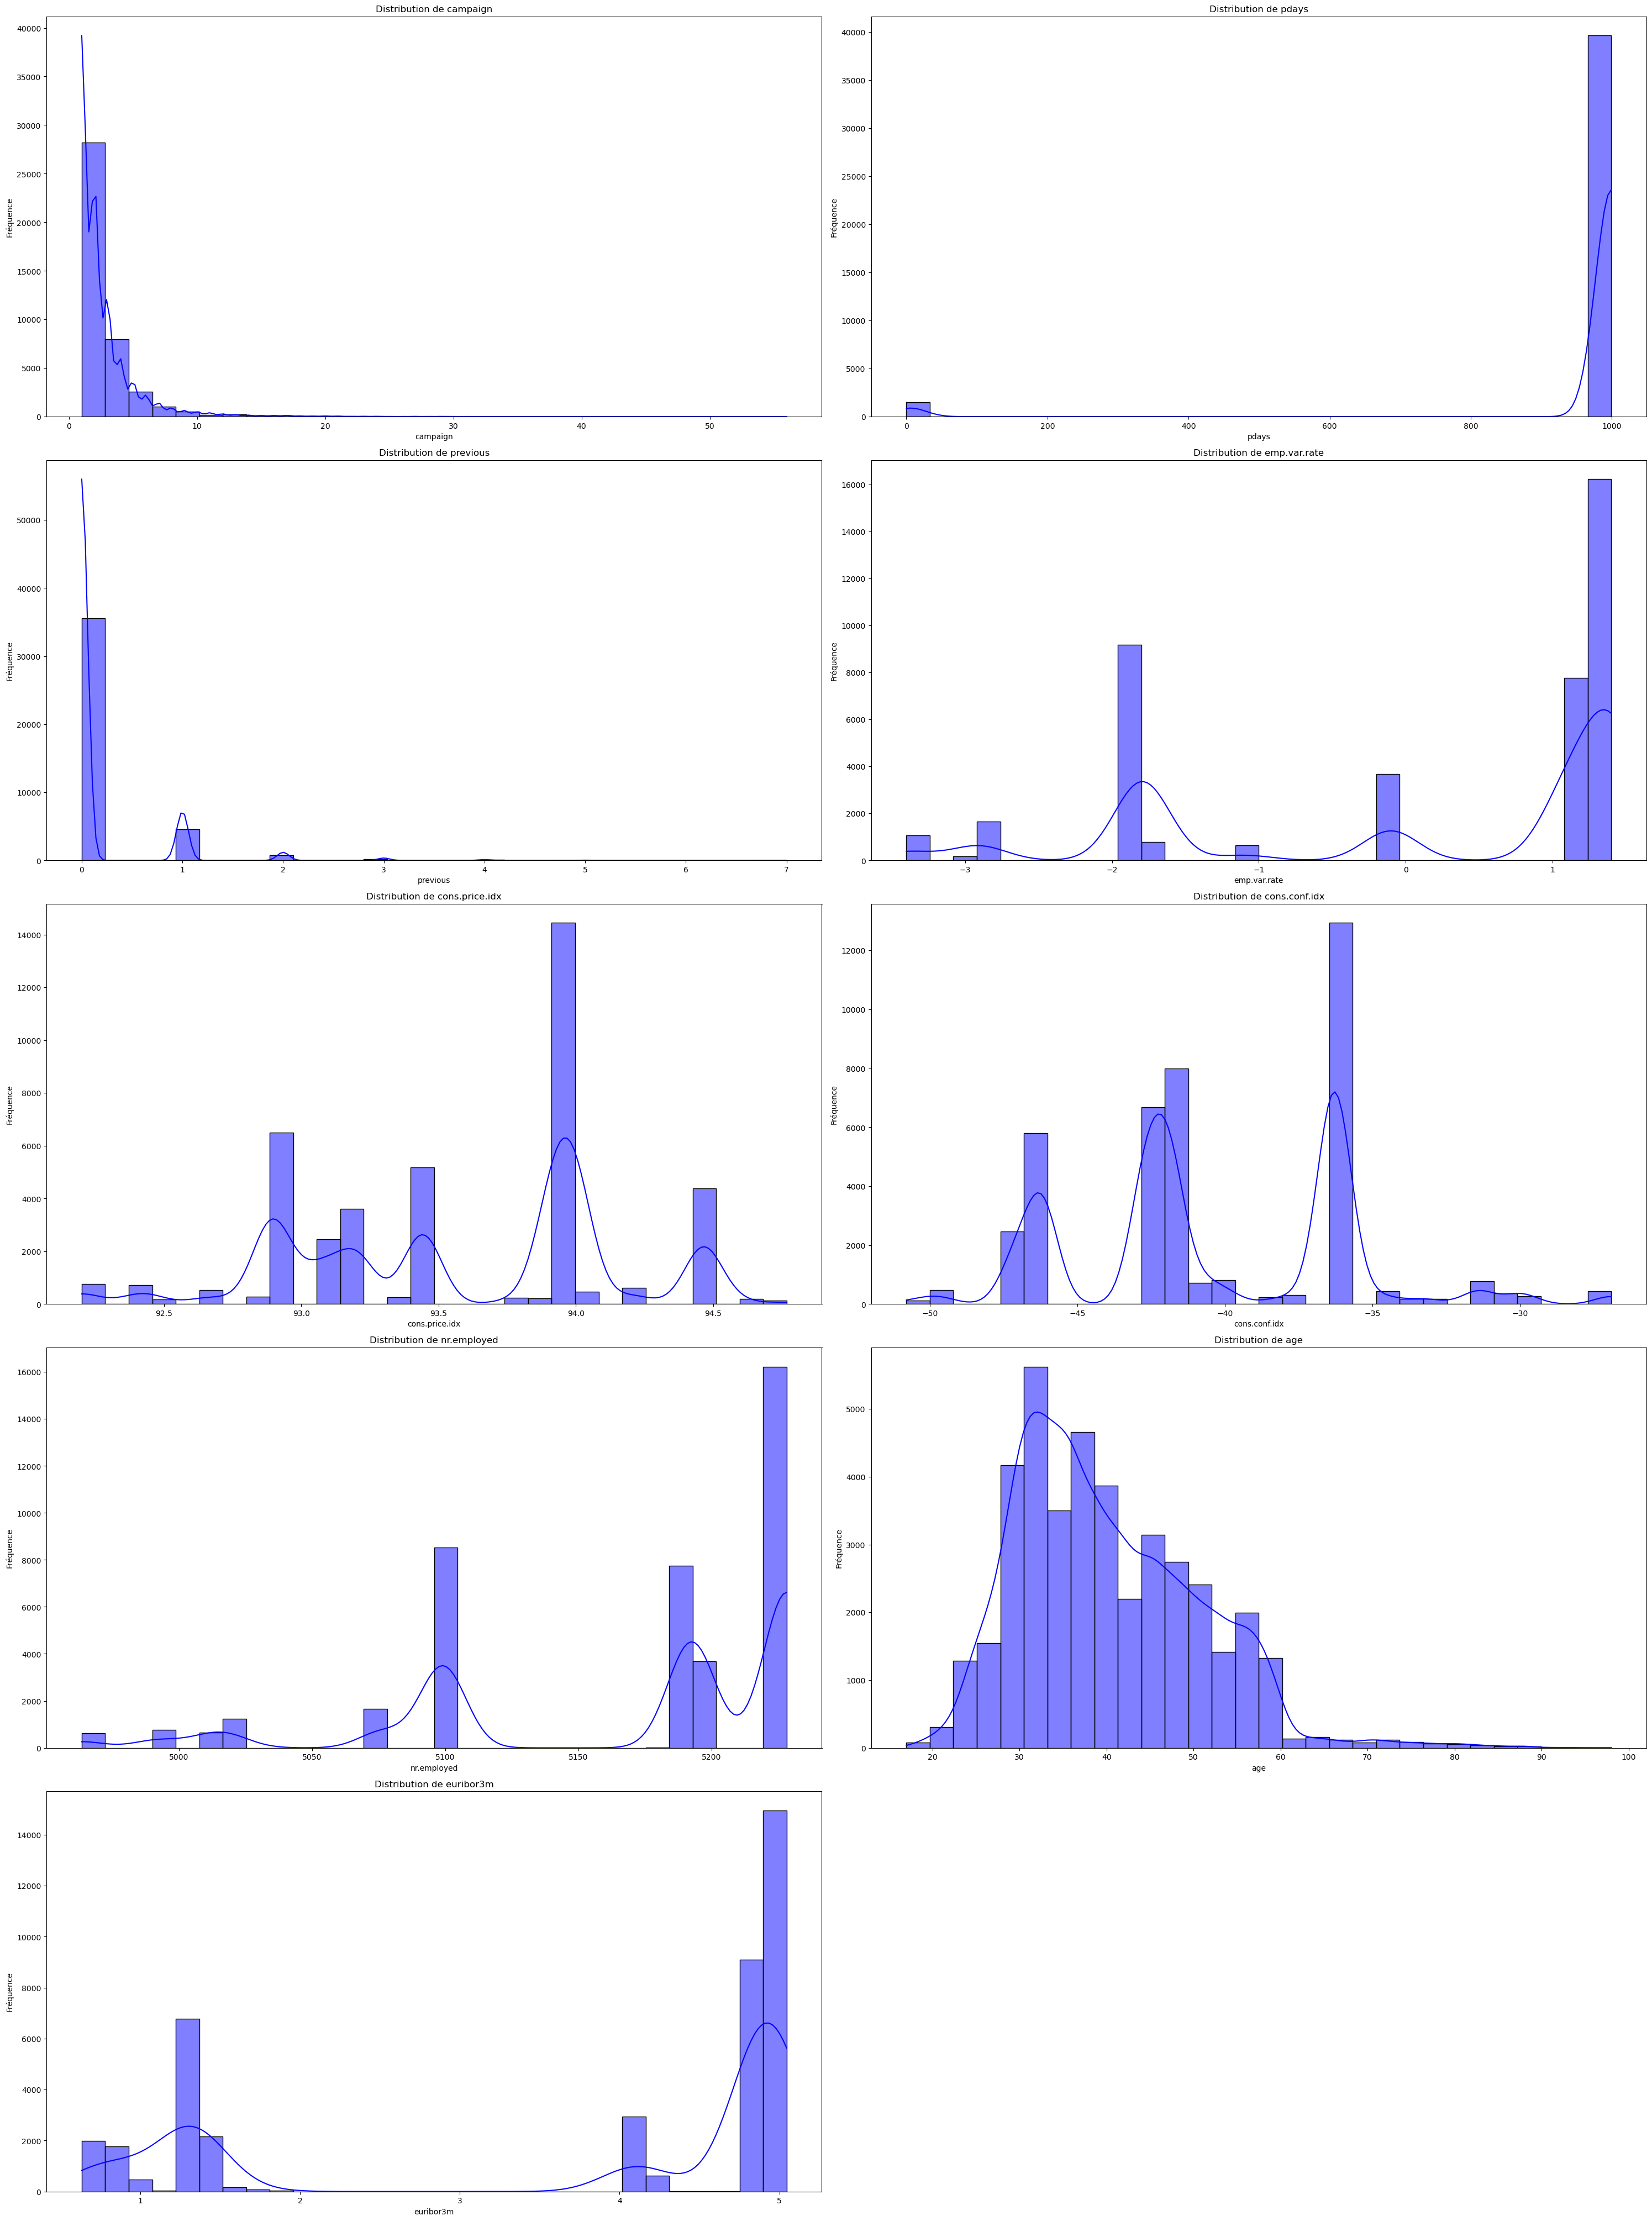

In [245]:
cols_num = ['campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'nr.employed','age','euribor3m']
def plot_numeric_distribution(df, numeric_columns):
    
    # Fonction pour tracer la distribution des variables numériques
    
    plt.figure(figsize=(30, len(numeric_columns) * 8))
    
    for i, col in enumerate(numeric_columns):
        plt.subplot(len(numeric_columns), 2, i + 1)
        sns.histplot(df[col], kde=True, bins=30, color='blue')
        plt.title(f'Distribution de {col}')
        plt.xlabel(col)
        plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()

plot_numeric_distribution(df, cols_num)

on peut aussi visualiser les relations entre les variables catégorielles et la variable cible:


Analyse des variables catégorielles par rapport à la cible :


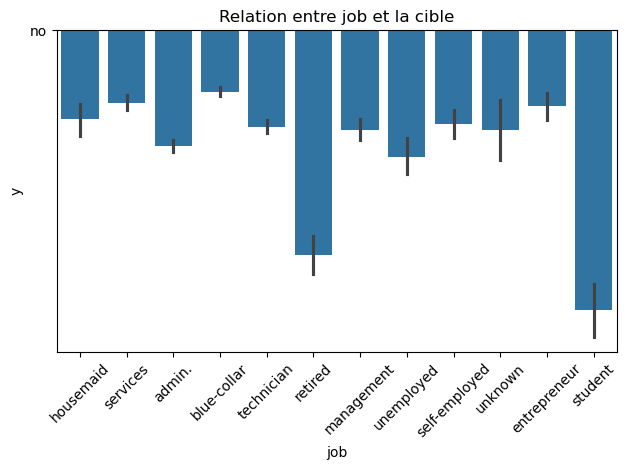

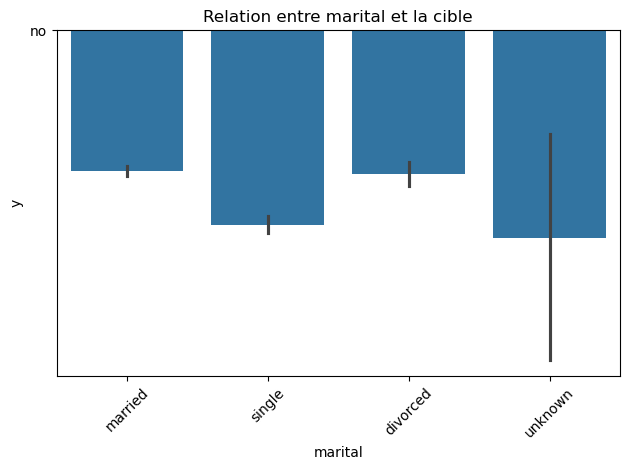

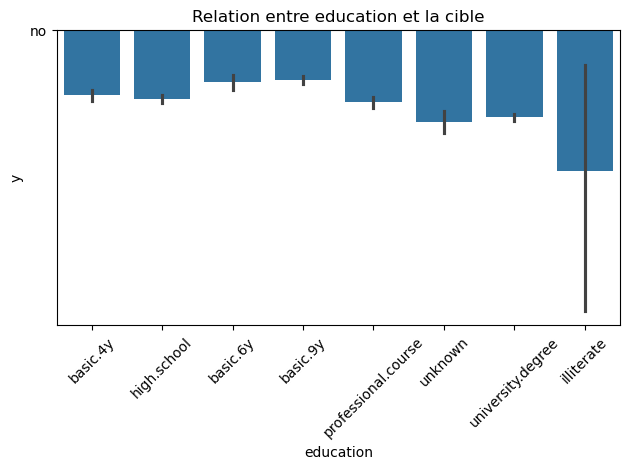

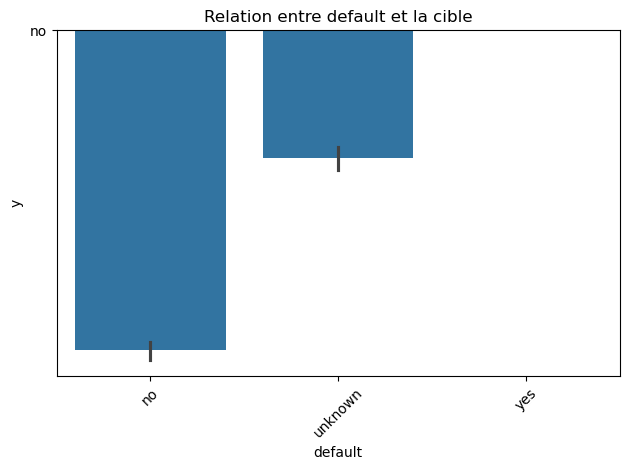

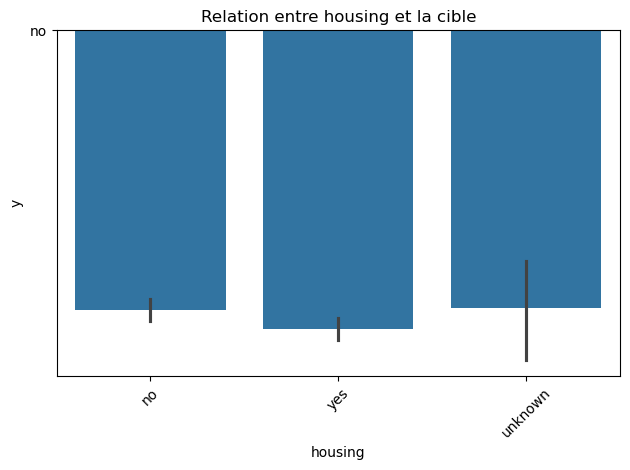

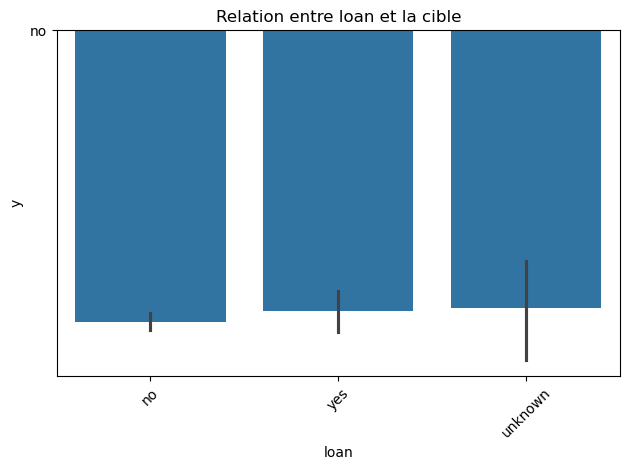

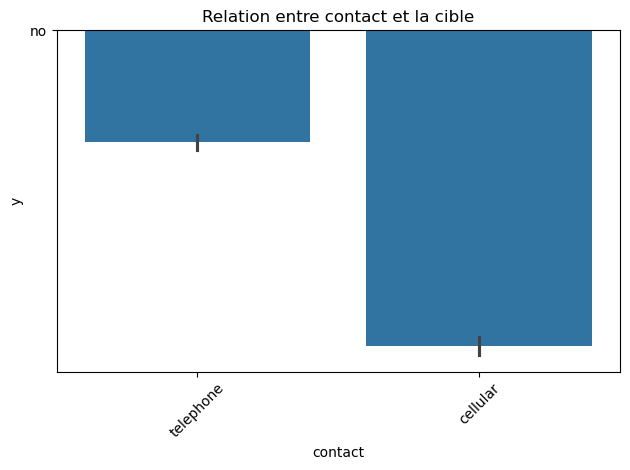

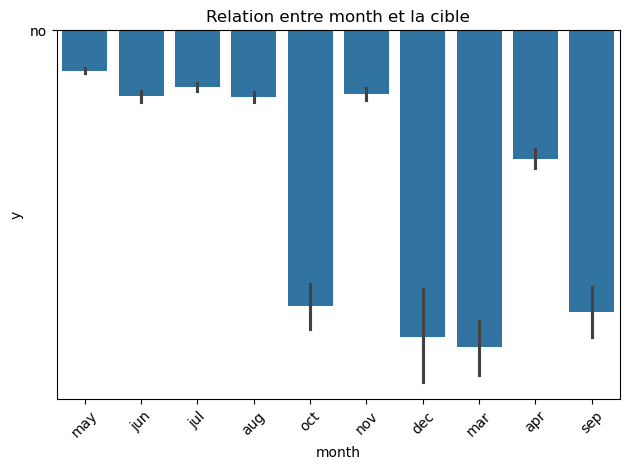

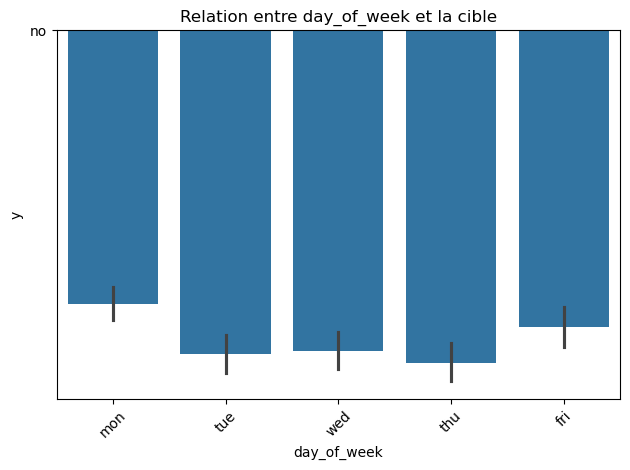

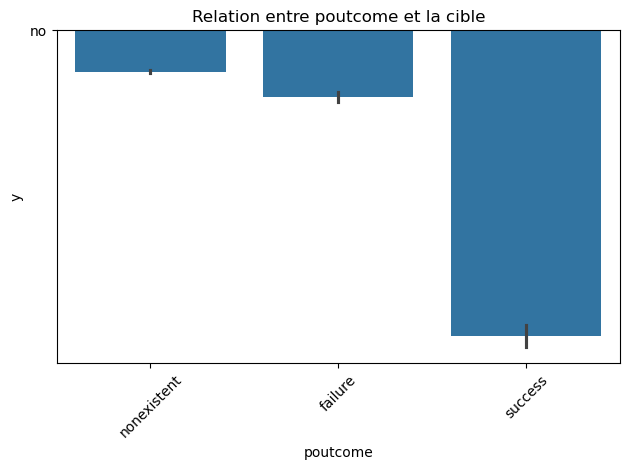

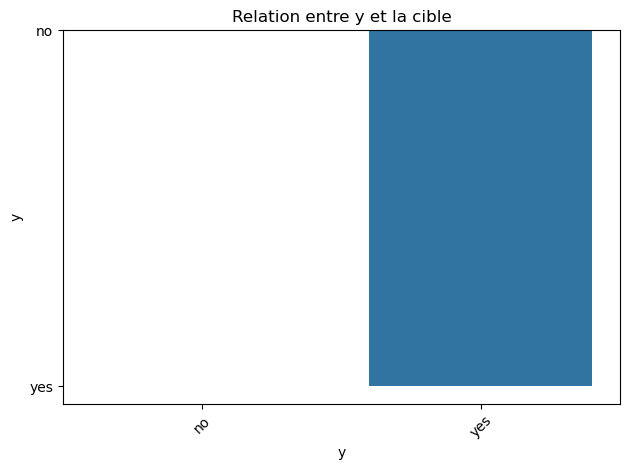

In [246]:
# Distribution des catégories par rapport à la cible
print("\nAnalyse des variables catégorielles par rapport à la cible :")
if 'y' in df.columns:  
    for col in df.select_dtypes(include=['object']).columns:
        sns.barplot(x=col, y='y', data=df)
        plt.title(f'Relation entre {col} et la cible')
        plt.xticks(rotation=45)  # Rotation des étiquettes
        plt.tight_layout()
        plt.show()

## 4- Transforamtion des données: 



Certaines variables numériques comme `duration`, `campaign`, `pdays`, `previous` ont une **distribution très déséquilibrée** avec des valeurs extrêmes.  
Nous allons appliquer une transformation logarithmique avec `log1p(x)` (équivalent à log(x + 1)) pour :
- Réduire l’impact des valeurs extrêmes
- Rendre les distributions plus proches de la normale


In [247]:
df['duration_log'] = np.log1p(df['duration'])
df['campaign_log'] = np.log1p(df['campaign'])
df['pdays_log'] = np.log1p(df['pdays'])
df['previous_log'] = np.log1p(df['previous'])

In [248]:

df['y'] = df['y'].map({'no': 0, 'yes': 1}) #encodage de la variable cible 

## 5- Encodage (One-Hot Encoding).

In [249]:
# cette fonction applique le one hot encoding sur toutes les colonnes de types object 
# cela represente dans notre cas, toute nos variables catégorielles
def one_hot_encode_object(df):
    colonnes_categorique = df.select_dtypes(include=['object']).columns

    # Appliquer le One Hot Encoding
    df_encoded = pd.get_dummies(df, columns=colonnes_categorique, drop_first=True)

    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:  
            df_encoded[col] = df_encoded[col].astype(int)
    return df_encoded
df= one_hot_encode_object(df)
print("Dimensions finales du DataFrame :", df.shape)
print(df.head())

Dimensions finales du DataFrame : (41176, 58)
   age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1    999         0           1.1          93.994   
1   57       149         1    999         0           1.1          93.994   
2   37       226         1    999         0           1.1          93.994   
3   40       151         1    999         0           1.1          93.994   
4   56       307         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  ...  month_may  month_nov  \
0          -36.4      4.857       5191.0  ...          1          0   
1          -36.4      4.857       5191.0  ...          1          0   
2          -36.4      4.857       5191.0  ...          1          0   
3          -36.4      4.857       5191.0  ...          1          0   
4          -36.4      4.857       5191.0  ...          1          0   

   month_oct  month_sep  day_of_week_mon  day_of_week_thu  day_o

## 6. Normalisation :

Les variables numériques peuvent avoir des ordres de grandeur très différents (par exemple, `duration` varie entre 0 et 5000).  
➡️ Certains algorithmes comme **KNN** utilisent des distances (euclidienne), donc la **normalisation est cruciale** pour éviter que des variables dominent les autres.

Nous allons appliquer la formule :  
**x_norm = (x - min) / (max - min)**


In [250]:
def normaliser_toutes_colonnes_numeriques(df):
   
    # Normalisation des colonnes numériques
    for colonne in df.select_dtypes(include=['float64', 'int64']).columns:
        min_value = df[colonne].min()
        max_value = df[colonne].max()
        if min_value != max_value:  # Éviter de diviser par zéro
            df[colonne] = (df[colonne] - min_value) / (max_value - min_value)
    return df

df = normaliser_toutes_colonnes_numeriques(df)
print("Statistiques après normalisation :")
print(df[cols_to_scale].describe().T)

Statistiques après normalisation :
                  count      mean       std  min       25%       50%  \
age             41176.0  0.284244  0.128650  0.0  0.185185  0.259259   
duration        41176.0  0.052525  0.052726  0.0  0.020740  0.036600   
campaign        41176.0  0.028507  0.050369  0.0  0.000000  0.018182   
pdays           41176.0  0.963428  0.187124  0.0  1.000000  1.000000   
previous        41176.0  0.024716  0.070709  0.0  0.000000  0.000000   
emp.var.rate    41176.0  0.725400  0.327267  0.0  0.333333  0.937500   
cons.price.idx  41176.0  0.535744  0.225580  0.0  0.340608  0.603274   
cons.conf.idx   41176.0  0.430843  0.193634  0.0  0.338912  0.376569   
euribor3m       41176.0  0.677237  0.393207  0.0  0.160961  0.957379   
nr.employed     41176.0  0.769130  0.273162  0.0  0.512287  0.859735   
duration_log    41176.0  0.608543  0.107869  0.0  0.545207  0.611526   
campaign_log    41176.0  0.127141  0.146700  0.0  0.000000  0.121038   
pdays_log       41176.0  0.97

## 7.Détection des corrélation 

<Figure size 1800x1600 with 0 Axes>

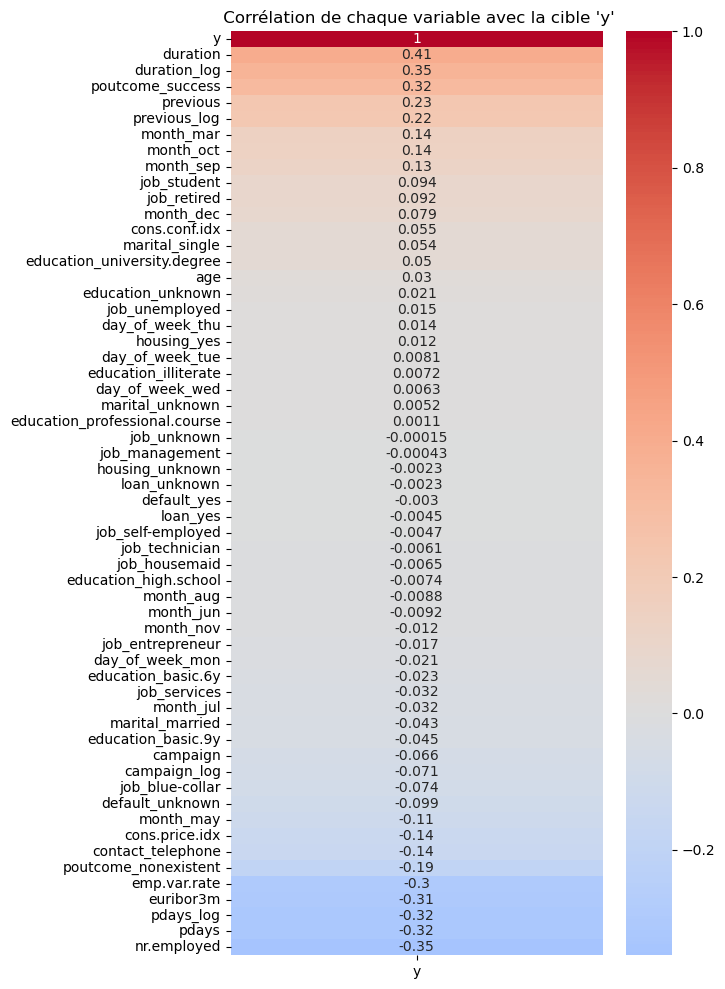

In [251]:

plt.figure(figsize=(18, 16))
corr_matrix_full = df.corr()


plt.figure(figsize=(6, 12))
sns.heatmap(corr_matrix_full[['y']].sort_values(by='y', ascending=False), annot=True, cmap='coolwarm', center=0)
plt.title(" Corrélation de chaque variable avec la cible 'y'")
plt.show()



### 7.1 suppression des variables à faible corrélation 

In [252]:
import pandas as pd
import numpy as np

def get_low_correlation_columns_with_target(df, target, threshold=0.1):
    """
    Récupère les colonnes ayant une corrélation absolue inférieure au seuil
    avec la variable cible.
    """
    corr_matrix = df.corr()  # Calcul de la matrice de corrélation
    low_corr_columns = [col for col in corr_matrix.columns 
                        if col != target and abs(corr_matrix[col][target]) < threshold]
    return low_corr_columns


def drop_columns_by_list(df, columns_to_drop):
    """
    Supprime les colonnes spécifiées dans la liste `columns_to_drop` du DataFrame.
    """
    df = df.drop(columns=columns_to_drop, axis=1)
    return df


In [253]:

corr_matrix = df.corr()
correlation_with_y = corr_matrix['y'].sort_values(ascending=False)
print("Corrélation avec y (ordre décroissant) :")
print(correlation_with_y)

selected_features = get_low_correlation_columns_with_target(df, 'y', threshold=0.1)

df= drop_columns_by_list(df, selected_features)



Corrélation avec y (ordre décroissant) :
y                                1.000000
duration                         0.405297
duration_log                     0.351016
poutcome_success                 0.316302
previous                         0.230202
previous_log                     0.222967
month_mar                        0.144027
month_oct                        0.137538
month_sep                        0.126079
job_student                      0.093962
job_retired                      0.092364
month_dec                        0.079311
cons.conf.idx                    0.054802
marital_single                   0.054209
education_university.degree      0.050267
age                              0.030381
education_unknown                0.021476
job_unemployed                   0.014749
day_of_week_thu                  0.013797
housing_yes                      0.011804
day_of_week_tue                  0.008123
education_illiterate             0.007246
day_of_week_wed                  0.

### 7.2 suppression des varaibles à forte correlation 


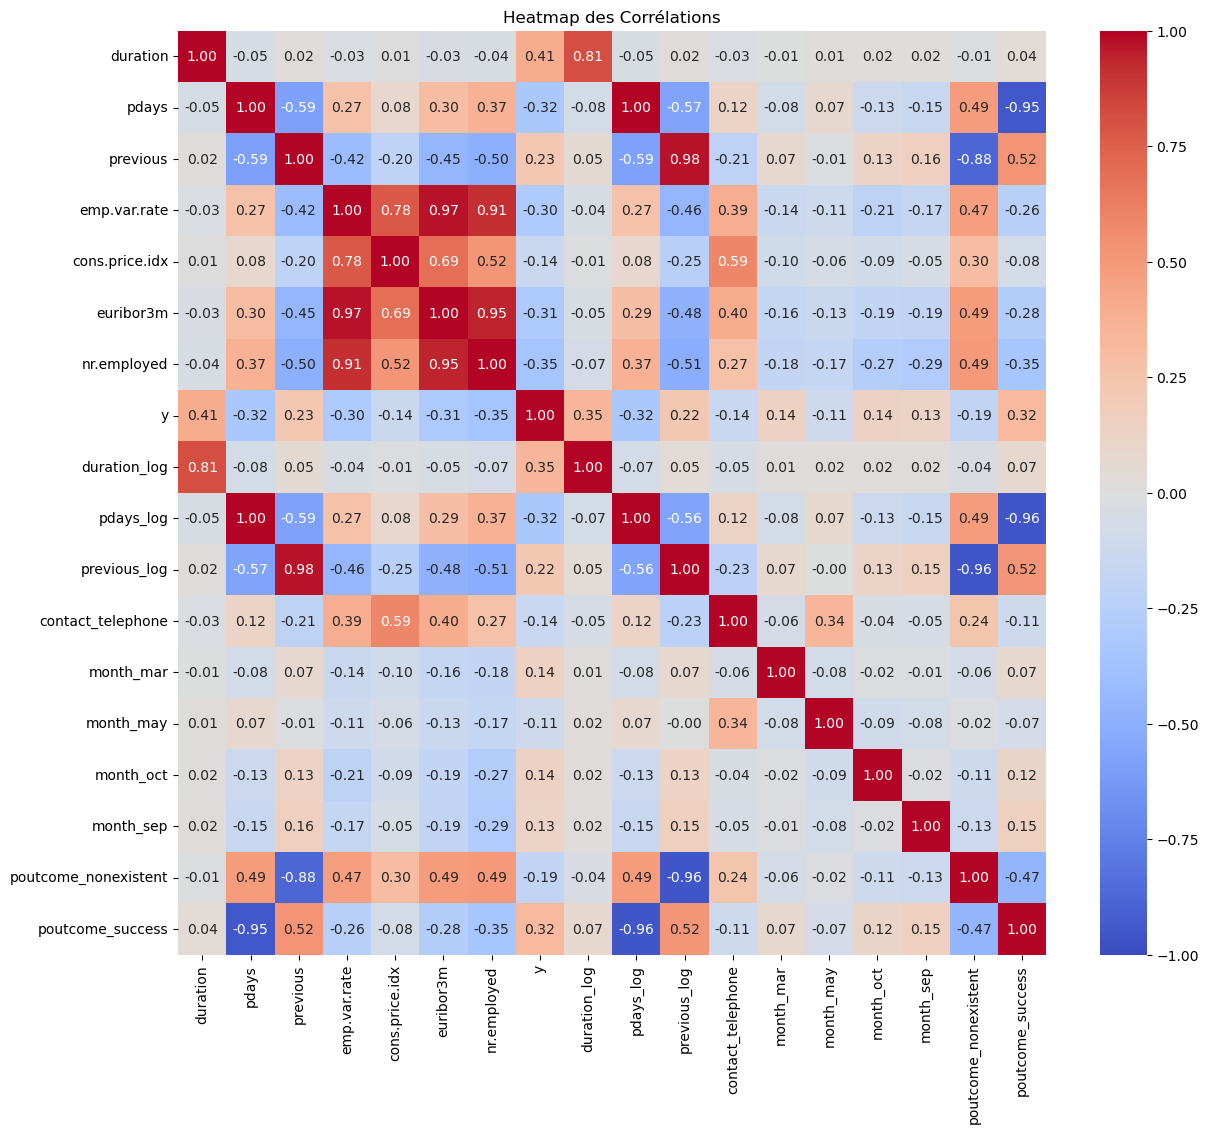

In [254]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df):
    """
    Trace une heatmap des corrélations pour le DataFrame donné.
    
    Paramètres :
    - df : DataFrame contenant les colonnes réduites.
    """
    plt.figure(figsize=(14, 12))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Heatmap des Corrélations")
    plt.show()

# Appeler la fonction avec votre DataFrame
plot_heatmap(df)


In [255]:
# Affiche les couples de variables avec une corrélation > 0.9 (sauf avec elles-mêmes)
corr_matrix = df.corr().abs()
high_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
             .stack()
             .sort_values(ascending=False))
print("Paires de variables fortement corrélées (> 0.9) :")
print(high_corr[high_corr > 0.9])


Paires de variables fortement corrélées (> 0.9) :
pdays         pdays_log               0.995077
previous      previous_log            0.976339
emp.var.rate  euribor3m               0.972244
previous_log  poutcome_nonexistent    0.959024
pdays_log     poutcome_success        0.955628
pdays         poutcome_success        0.950700
euribor3m     nr.employed             0.945146
emp.var.rate  nr.employed             0.906949
dtype: float64


In [259]:
cols_to_drop = [
    'pdays', 'previous',
     'euribor3m', 'poutcome_nonexistent',
    'poutcome_success', 'nr.employed', 
    'contact_telephone',  
    'poutcome_nonexistent',
    'pdays_log'
]

df= drop_columns_by_list(df, cols_to_drop)
print("Vérification  :", df.shape)


Vérification  : (41176, 10)


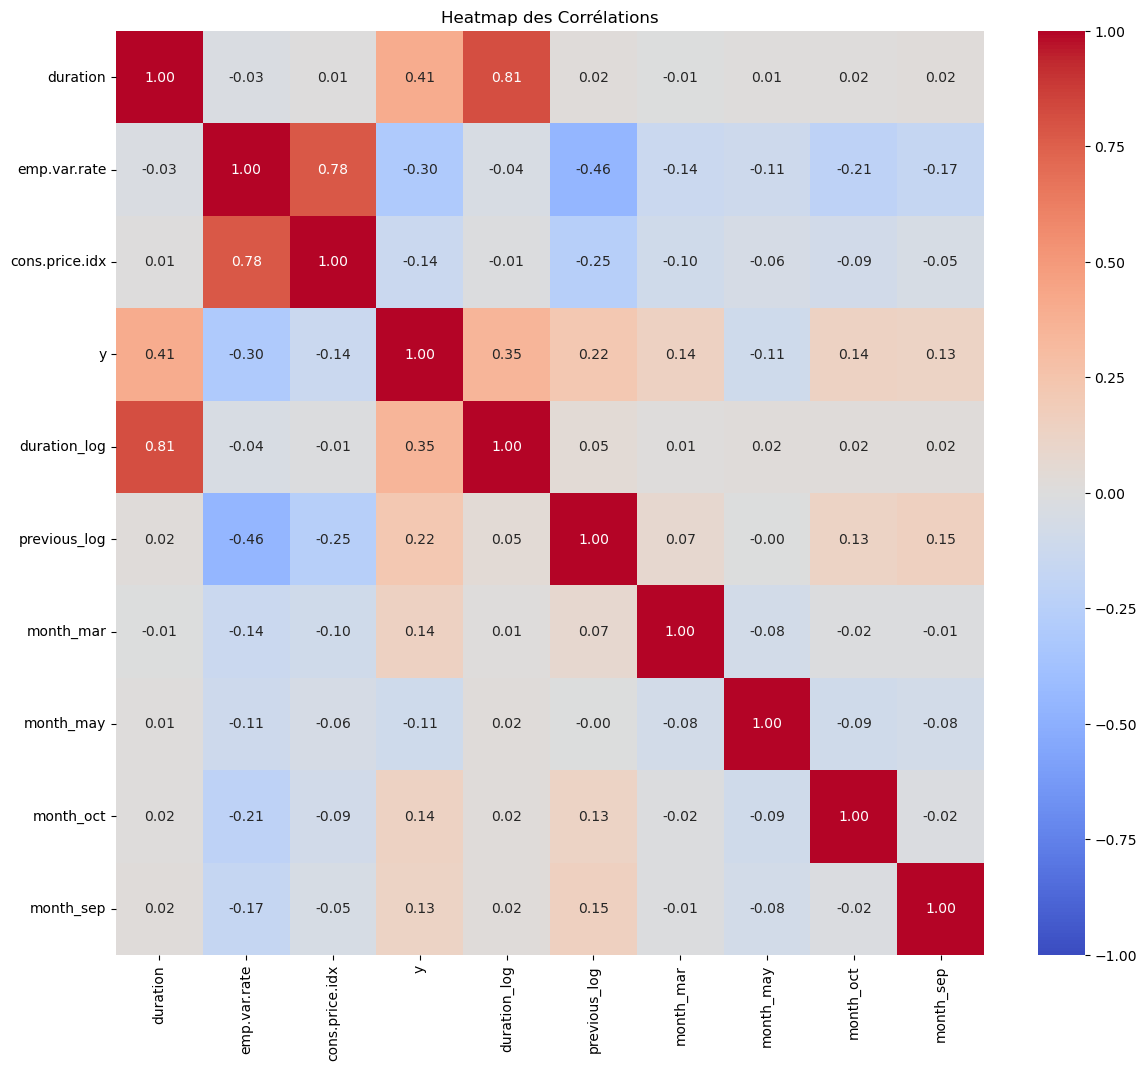

In [261]:

plot_heatmap(df)


## 8.Modélisation (TRAINNIG, VALIDATION, TEST SAMPLES)

### 8.1- Desicion Tree 

- Séparons nos données maintenant 

In [262]:
X = df.drop(columns=["y"])  
y = df["y"]  


print("X shape :", X.shape)
print("y shape :", y.shape)
print("Répartition de y :\n", y.value_counts(normalize=True))


X shape : (41176, 9)
y shape : (41176,)
Répartition de y :
 y
0.0    0.887337
1.0    0.112663
Name: proportion, dtype: float64


- D'apres ces resultats on peut remarque facilment que y'a un desiquilibre entre les clients sont souscrit 11 % et 88% des clients n'ont pas sousrit 
- X est  la variable explicatives (tout les autres varaibale qu'on a essayé d'affiner et qu'on pretraité)
- Y nottre variable cible ce qu'on essaye de predire 

In [263]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)


X_resampled, y_resampled = smote.fit_resample(X, y)


print("Après SMOTE :")
print("X_resampled shape :", X_resampled.shape)
print("y_resampled distribution :\n", y_resampled.value_counts(normalize=True))


Après SMOTE :
X_resampled shape : (73074, 9)
y_resampled distribution :
 y
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


- Vu qu'on a trouver que les variables ne sont pas equilibrer donc apres des recherches j'ai trouver une methode pour reequilibrer les variables 
- Smote( sythetic minority over sampling technique) est une technique utilisée pour équilibrer un data set générant des exemples synthétiques de la classe minoritaire ici dans notre situation les clients qui s"ont dis oui

In [264]:
from sklearn.model_selection import train_test_split

# Séparation du jeu de données équilibré
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,  # pour garder la proportion 50/50 dans chaque partie
    random_state=42
)

# Vérification
print(" Jeux de données prêts :")
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.value_counts(normalize=True))
print("y_test  :", y_test.value_counts(normalize=True))


 Jeux de données prêts :
X_train : (58459, 9)
X_test  : (14615, 9)
y_train : y
1.0    0.500009
0.0    0.499991
Name: proportion, dtype: float64
y_test  : y
0.0    0.500034
1.0    0.499966
Name: proportion, dtype: float64


In [ ]:
# Modèle avec les meilleurs paramètres
from sklearn.tree import DecisionTreeClassifier


best_tree = DecisionTreeClassifier(
    class_weight=None,   
    max_depth=None,      
    min_samples_split=2, 
    min_samples_leaf=1,  
    random_state=42
)

# Entraînement du modèle
best_tree.fit(X_train, y_train)

# Prédictions
y_pred_best_tree = best_tree.predict(X_test)

# Évaluation
print(" Arbre de décision avec meilleurs paramètres")
print(classification_report(y_test, y_pred_best_tree))
roc_auc_best = roc_auc_score(y_test, best_tree.predict_proba(X_test)[:, 1])
print("AUC-ROC Score avec meilleurs paramètres :", roc_auc_best)


 Arbre de décision avec meilleurs paramètres
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      7308
         1.0       0.91      0.86      0.88      7307

    accuracy                           0.89     14615
   macro avg       0.89      0.89      0.89     14615
weighted avg       0.89      0.89      0.89     14615

AUC-ROC Score avec meilleurs paramètres : 0.8964308991632814


### 8.2- KNN (K-Nearset Neighbors)

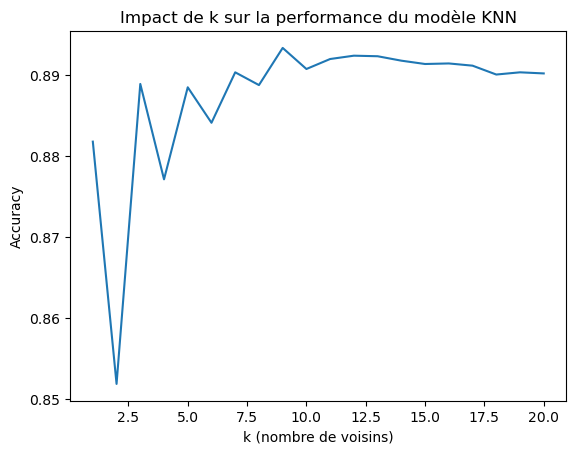

In [266]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Essayer différentes valeurs de k
k_range = range(1, 21)  # Tester de k=1 à k=20
scores = []

# Test de chaque valeur de k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    accuracy = classification_report(y_test, y_pred_knn, output_dict=True)['accuracy']
    scores.append(accuracy)

# Visualiser l'impact de k sur la performance
plt.plot(k_range, scores)
plt.xlabel('k (nombre de voisins)')
plt.ylabel('Accuracy')
plt.title('Impact de k sur la performance du modèle KNN')
plt.show()


- On remarque que d'apres ce graphe que le choix de K influence sur la precission du modèle donc le choix le plus optimal tout en gardant un nombre de voisin modèrer et une precission optimale est de 5 à 20

In [270]:

knn = KNeighborsClassifier(n_neighbors=4, metric='minkowski')


knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("KNN - Rapport de classification :")
print(classification_report(y_test, y_pred_knn))
# Calcul de l'AUC-ROC
roc_auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
print("KNN - AUC-ROC Score :", roc_auc_knn)


KNN - Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      7308
         1.0       0.89      0.86      0.88      7307

    accuracy                           0.88     14615
   macro avg       0.88      0.88      0.88     14615
weighted avg       0.88      0.88      0.88     14615

KNN - AUC-ROC Score : 0.9337340464029326


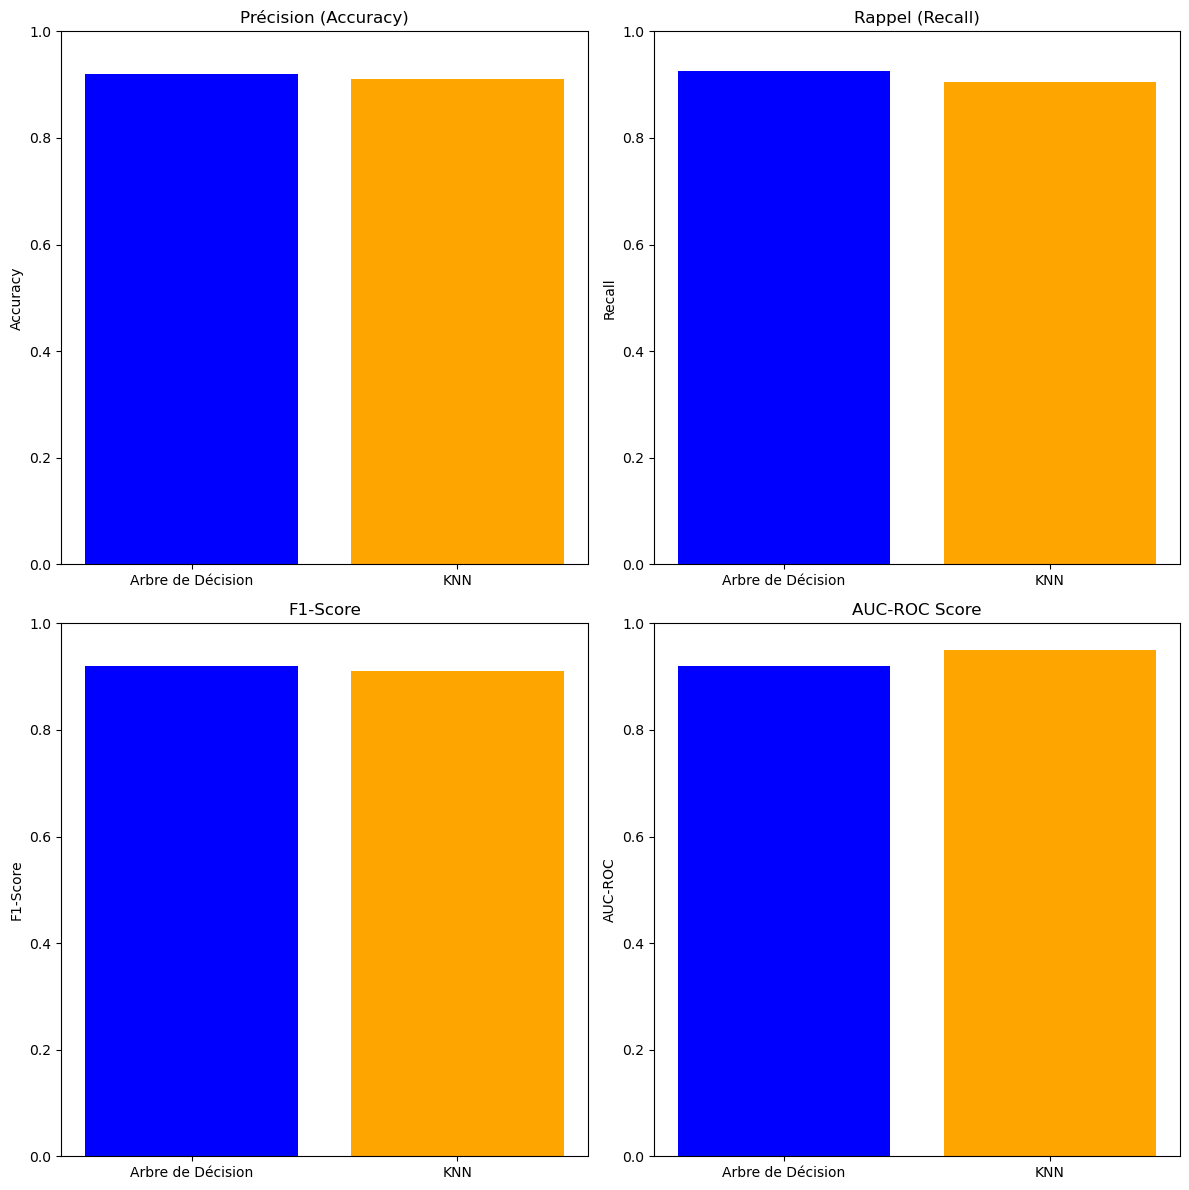

In [271]:

accuracy_tree = 0.92
precision_tree = [0.93, 0.92]  
recall_tree = [0.92, 0.93]     
f1_tree = [0.92, 0.92]         
roc_auc_tree = 0.92

accuracy_knn = 0.91
precision_knn = [0.93, 0.89]  
recall_knn = [0.88, 0.93]      
f1_knn = [0.91, 0.91]          
roc_auc_knn = 0.95


models = ['Arbre de Décision', 'KNN']

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Comparaison de l'accuracy
axes[0, 0].bar(models, [accuracy_tree, accuracy_knn], color=['blue', 'orange'])
axes[0, 0].set_title('Précision (Accuracy)')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_ylabel('Accuracy')

# Comparaison du rappel
axes[0, 1].bar(models, [np.mean(recall_tree), np.mean(recall_knn)], color=['blue', 'orange'])
axes[0, 1].set_title('Rappel (Recall)')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_ylabel('Recall')

# Comparaison du F1-score
axes[1, 0].bar(models, [np.mean(f1_tree), np.mean(f1_knn)], color=['blue', 'orange'])
axes[1, 0].set_title('F1-Score')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_ylabel('F1-Score')

# Comparaison de l'AUC-ROC
axes[1, 1].bar(models, [roc_auc_tree, roc_auc_knn], color=['blue', 'orange'])
axes[1, 1].set_title('AUC-ROC Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_ylabel('AUC-ROC')

# Affichage des graphiques
plt.tight_layout()
plt.show()


- On remarque d'apres c'est graphe que les resultats de la prediction sont assez proche et que les deux modèle donnent des resultat optimal 

### 8.3- Random Forest avec GridSearchCV:

In [272]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# 1. Modèle de base
rf = RandomForestClassifier(random_state=42)

# 2. Dictionnaire des hyperparamètres à tester
param_grid = {
    'n_estimators': [200],
    'max_depth': [5],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'class_weight': ['balanced']
}

# 3. Recherche avec GridSearchCV (ça tournera très vite ici)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3,
                           n_jobs=-1, verbose=2, scoring='accuracy')

# 4. Entraînement
grid_search.fit(X_train, y_train)

# 5. Résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest - Rapport de classification :")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
print("Random Forest - AUC-ROC Score :", roc_auc_rf)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Meilleurs hyperparamètres : {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      7308
         1.0       0.84      0.94      0.89      7307

    accuracy                           0.88     14615
   macro avg       0.89      0.88      0.88     14615
weighted avg       0.89      0.88      0.88     14615

Random Forest - AUC-ROC Score : 0.9380254397620834


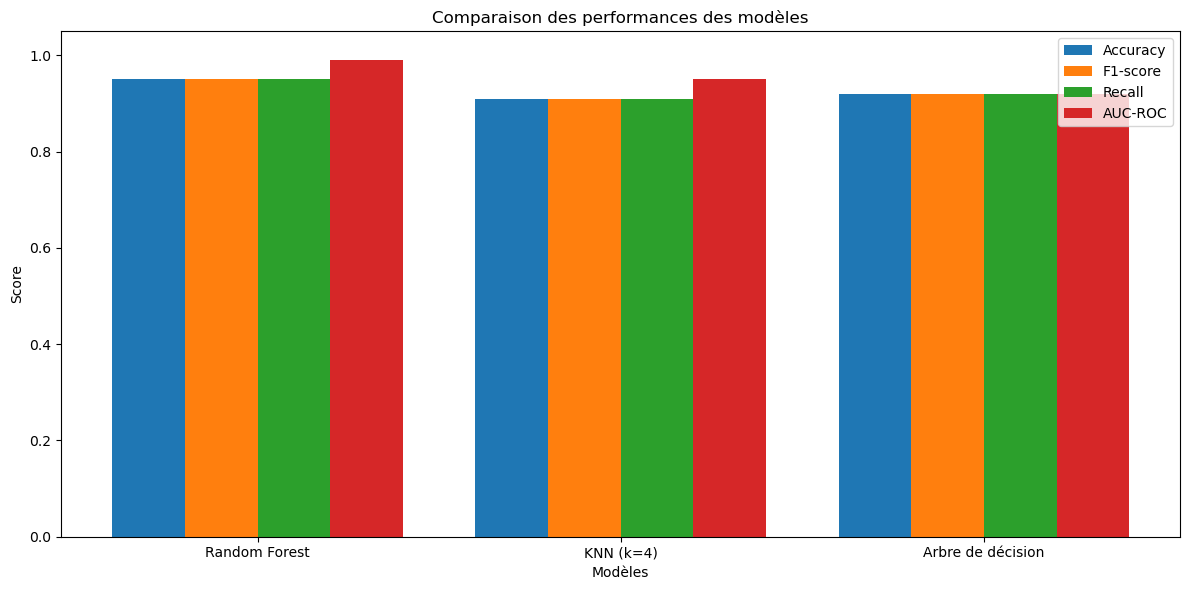

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Noms des modèles
models = ['Random Forest', 'KNN (k=4)', 'Arbre de décision']

# Résultats
accuracy = [0.95, 0.91, 0.92]
f1 = [0.95, 0.91, 0.92]
recall = [0.95, 0.91, 0.92]
roc_auc = [0.99, 0.95, 0.92]

# Organisation en tableau
scores = {
    'Accuracy': accuracy,
    'F1-score': f1,
    'Recall': recall,
    'AUC-ROC': roc_auc
}

# Création des graphes
x = np.arange(len(models))  # positions des barres
width = 0.2  # largeur des barres

fig, ax = plt.subplots(figsize=(12, 6))

# Dessiner les barres pour chaque métrique
for i, (metric, values) in enumerate(scores.items()):
    ax.bar(x + i * width, values, width, label=metric)

# Configurations
ax.set_xlabel('Modèles')
ax.set_ylabel('Score')
ax.set_title('Comparaison des performances des modèles')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()
